<a href="https://colab.research.google.com/github/Kkuntal990/IB/blob/master/Copy_of_IB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cleverhans

     |████████████████████████████████| 204kB 5.5MB/s 
     |████████████████████████████████| 163kB 13.9MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 


In [ ]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.metrics import confusion_matrix
#import plotcm
import sys
import tensorflow.keras as keras
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, ZeroPadding2D
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Lambda
import tensorflow.keras.models as models
import numpy as np
import os
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/IB/RML2016.10a_dict.dat" /content/

In [ ]:
#import cPickle

os.environ["KERAS_BACKEND"] = "tensorflow"
sys.path.append('../confusion')

name = 'CNN2'

In [ ]:
with open("RML2016.10a_dict.dat", 'rb') as xd1:  
    Xd = pickle.load(xd1, encoding='latin1')  # , encoding='latin1'
snrs, mods = map(lambda j: sorted(
    list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
X = []
lbl = []
SNR = []
 
for mod in mods:
    for snr in snrs:
        SNR.append(snr)
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):
            lbl.append((mod, snr))
X = np.vstack(X)
# %%
np.random.seed(2016)  
n_examples = X.shape[0]
n_train = n_examples * 0.5  # ĺŻšĺ
train_idx = np.random.choice(
    range(0, n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0, n_examples)) - set(train_idx))  # label
test_idx2 = []
X_train = X[train_idx]
for i in test_idx:
    if SNR[i//1000] >= 0:
        test_idx2.append(i)
 
X_test = X[test_idx2]



97726


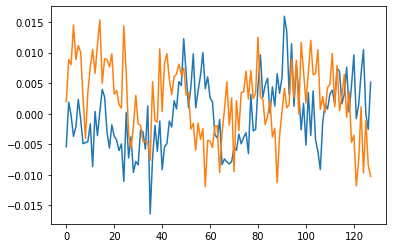

In [ ]:
ii = np.random.randint(0,X_train.shape[0])
print(ii)
t = np.arange(X_train.shape[2])
plt.plot(t, X_train[i, 0, :])
plt.plot(t, X_train[i, 1, :])
plt.show()

In [ ]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1


trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx2)))
# %%
in_shp = list(X_train.shape[1:])
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)
classes = mods
print(in_shp)


(110000, 2, 128) (55027, 2, 128)
(110000, 11) (55027, 11)
[2, 128]


In [ ]:
import tensorflow as tf
from tensorflow_probability import distributions as ds
import math

In [ ]:
def sample_z(args):
  mu, sigma = args
  batch = K.shape(mu)[0]
  dim = K.int_shape(mu)[1]
  eps = K.random_normal(shape=(batch, dim))
  return mu + K.log(1 + K.exp(sigma - 5.0)) * eps

BETA = 2*1e-3
prior = ds.Normal(0.0, 1.0)
dr = 0.5

In [ ]:
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)
        inp = keras.Input(shape=(2,128,))
        x = Reshape(target_shape=(2,128,1,))(inp)
        x = ZeroPadding2D((0,2), data_format="channels_first")(x)
        x = Conv2D(256, (1, 3), padding='valid', activation="relu", name="conv1",kernel_initializer='glorot_uniform')(x)
        x = Dropout(dr)(x)
        x = ZeroPadding2D((0, 2), data_format="channels_first")(x)
        x = Conv2D(80, (2, 3), padding="valid", activation="relu", name="conv2",kernel_initializer='glorot_uniform')(x)
        x = Dropout(dr)(x)
        x = Flatten()(x)
        x = Dense(512, activation='relu', name="mu",kernel_initializer='he_normal')(x)
        '''
        mu = Dense(128, activation='relu', name="mu")(x)
        mu = Dropout(dr)(mu)

        sigma = Dense(128, activation='relu', name="sigma")(x)
        sigma = Dropout(dr)(sigma)
        '''
        mu, sigma = x[:, :256], x[:, 256:]
        #z = keras.layers.Lambda(sample_z, output_shape=(256, ), name='z')([mu, sigma])
        encoder = keras.Model(inp, [mu,sigma], name="encoder")
        self.encoder = encoder
        z = keras.Input(shape=(256,))
        y = Dense(len(classes), name="dense3", activation='relu',kernel_initializer='he_normal')(z)
        decoder = keras.Model(z,y, name="decoder")
        self.decoder = decoder
        self.encoder.summary()
        self.decoder.summary()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.val_loss_tracker = keras.metrics.Mean(name="val_loss")
        self.class_loss_tracker = keras.metrics.Mean(
             name="class_loss"
         )
        self.info_loss_tracker = keras.metrics.Mean(name="info_loss")
        self.IZY_bound_tracker = keras.metrics.Mean(name="IZY_bound")
        self.IZX_bound_tracker = keras.metrics.Mean(name="IZX_bound")
        self.train_acc_tracker = keras.metrics.Mean(name="Training accuracy")
        self.val_acc_tracker = keras.metrics.Mean(name="validation accuracy")

    @property
    def metrics(self):
        return [
            self.class_loss_tracker,
            self.info_loss_tracker,
            self.total_loss_tracker,
            self.IZY_bound_tracker,
            self.IZX_bound_tracker
            ,self.train_acc_tracker
        ]

    def call(self, data):
      mu,sigma = self.encoder(data)
      sigma = tf.math.softplus(sigma-5.0)
      z_dist = ds.Normal(mu, sigma)
      z = z_dist.sample()
      y = self.decoder(z)
      return tf.nn.softmax(y)

    @tf.function
    def train_step(self, inp):
        data, y_true = inp
        with tf.GradientTape() as tape:
            mu,sigma = self.encoder(data)
            sigma = tf.math.softplus(sigma-5.0)
            z_dist = ds.Normal(mu, sigma)
            z = z_dist.sample()
            y = self.decoder(z)
            
          
            info_loss = tf.reduce_sum(tf.reduce_mean(ds.kl_divergence(z_dist, prior), 0)) /math.log(2)
            class_loss = tf.compat.v1.losses.softmax_cross_entropy(logits=y, onehot_labels=y_true)
            total_loss =  class_loss + BETA*info_loss
        training_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_true, axis=1)), tf.float32))
        IZY_bound =  math.log(10, 2) - class_loss
        IZX_bound = info_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.class_loss_tracker.update_state(class_loss)
        self.info_loss_tracker.update_state(info_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.IZY_bound_tracker.update_state(IZY_bound)
        self.IZX_bound_tracker.update_state(IZX_bound)
        self.train_acc_tracker.update_state(training_acc)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "info_loss": self.info_loss_tracker.result(),
            "class_loss": self.class_loss_tracker.result(),
            "IZY_bound" : self.IZY_bound_tracker.result(),
            "IZX_bound" : self.IZX_bound_tracker.result()
            ,"Train acc" : self.train_acc_tracker.result()
        }
    @tf.function
    def test_step(self, val_inp):
        x_val, y_val = val_inp
        mu,sigma = self.encoder(x_val)
        sigma = tf.math.softplus(sigma-5)
        z_dist = ds.Normal(mu, sigma)
        z = z_dist.sample()
        y = self.decoder(z)
        info_loss = tf.reduce_sum(tf.reduce_mean(ds.kl_divergence(z_dist, prior), 0)) /math.log(2)
        class_loss = tf.compat.v1.losses.softmax_cross_entropy(logits=y, onehot_labels=y_val)
        val_loss =  class_loss + BETA*info_loss
        val_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(tf.nn.softmax(y), 1), tf.argmax(y_val, axis=1)), tf.float32))
        self.val_loss_tracker.update_state(val_loss)
        self.val_acc_tracker.update_state(val_acc)
        return {
            "acc" : self.val_acc_tracker.result(),
            "loss" : self.val_loss_tracker.result()
        }



In [ ]:
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam(lr=5e-4), metrics=[tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')])
history = vae.fit(X_train,Y_train,validation_data=(X_test, Y_test), epochs=10000, batch_size=1024, callbacks=[keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/IB_checkpoints/', monitor='val_loss', verbose=0, save_best_only=True,
                                                        mode='auto'),keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 2, 128, 1)    0           input_5[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 2, 128, 5)    0           reshape_2[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 2, 126, 256)  4096        zero_padding2d_4[0][0]           
____________________________________________________________________________________________

In [ ]:
vae = VAE()
vae.load_weights('/content/drive/MyDrive/IB_checkpoints/checkpoint')


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 128, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 2, 128, 5)    0           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 2, 126, 256)  4096        zero_padding2d_2[0][0]           
____________________________________________________________________________________________

In [ ]:
Y_pred = np.argmax(vae(X_test[:10000]),axis=1)
Y_test2 = np.argmax(Y_test,axis=1)
co = 0
for i in range(10000):
  if(Y_test2[i]==Y_pred[i]):
    co+=1
print(co/10000)

0.5825


In [ ]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.savefig('%s Training performance' % (name))
# plt.show()

model.load_weights(filepath)
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print('evaluate_score:', score)


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title)
    # plt.show()


# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)

# %%č°ç¨ĺşäş§çćˇˇćˇçŠéľ
pre_labels = []
for x in test_Y_hat:
    tmp = np.argmax(x, 0)
    pre_labels.append(tmp)
true_labels = []
for x in Y_test:
    tmp = np.argmax(x, 0)
    true_labels.append(tmp)

kappa = cohen_kappa_score(pre_labels, true_labels)
oa = accuracy_score(true_labels, pre_labels)
kappa_oa = {}
print('oa_all:', oa)
print('kappa_all:', kappa)
kappa_oa['oa_all'] = oa
kappa_oa['kappa_all'] = kappa
fd = open('results_all_%s_d0.5.dat' % (name), 'wb')
cPickle.dump(("%s" % (name), 0.5, kappa_oa), fd)
fd.close()
cnf_matrix = confusion_matrix(true_labels, pre_labels)
# np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
# plt.figure()
plotcm.plot_confusion_matrix(cnf_matrix, classes=classes,
                             normalize=False,
                             title='%s Confusion matrix, without normalization' % (name), showtext=True)
plt.savefig('%s Confusion matrix, without normalization' % (name))
# Plot normalized confusion matrix
# plt.figure()
plotcm.plot_confusion_matrix(cnf_matrix, classes=classes,
                             normalize=True,
                             title='%s Normalized confusion matrix' % (name), showtext=True)
plt.savefig('%s Normalized confusion matrix' % (name))
# plt.show()

# %%čŞĺŽäšäş§çćˇˇćˇçŠéľ
conf = np.zeros([len(classes), len(classes)])
confnorm = np.zeros([len(classes), len(classes)])
for i in range(0, X_test.shape[0]):
    j = list(Y_test[i, :]).index(1)
    k = int(np.argmax(test_Y_hat[i, :]))
    conf[j, k] += 1
for i in range(0, len(classes)):
    confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
plot_confusion_matrix(confnorm, labels=classes,
                      title='%s Confusion matrix' % (name))

# %%Plot confusion matrix çťĺž
acc = {}
kappa_dict = {}
oa_dict = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)

    # %%č°ç¨ĺşäş§çćˇˇćˇçŠéľ
    pre_labels_i = []
    for x in test_Y_i_hat:
        tmp = np.argmax(x, 0)
        pre_labels_i.append(tmp)
    true_labels_i = []
    for x in test_Y_i:
        tmp = np.argmax(x, 0)
        true_labels_i.append(tmp)
    kappa = cohen_kappa_score(pre_labels_i, true_labels_i)
    oa = accuracy_score(true_labels_i, pre_labels_i)
    oa_dict[snr] = oa
    kappa_dict[snr] = kappa
    cnf_matrix = confusion_matrix(true_labels_i, pre_labels_i)
    # np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    # plt.figure()
    plotcm.plot_confusion_matrix(cnf_matrix, classes=classes,
                                 normalize=False,
                                 title='%s Confusion matrix, without normalization (SNR=%d)' % (name, snr), showtext=True)
    plt.savefig('%s Confusion matrix, without normalization (SNR=%d)' %
                (name, snr))
    # Plot normalized confusion matrix
    # plt.figure()
    plotcm.plot_confusion_matrix(cnf_matrix, classes=classes,
                                 normalize=True,
                                 title='%s Normalized confusion matrix (SNR=%d)' % (name, snr), showtext=True)
    plt.savefig('%s Normalized confusion matrix (SNR=%d)' % (name, snr))
    # plt.show()

    # %%čŞĺŽäšäş§çćˇˇćˇçŠéľ
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] += 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
    # plt.figure()
    plot_confusion_matrix(confnorm, labels=classes,
                          title="%s Confusion Matrix (SNR=%d)" % (name, snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor + ncor))
    acc[snr] = 1.0 * cor / (cor + ncor)

# %%Save results to a pickle file for plotting later
print 'acc:', acc
fd = open('results_%s_d0.5.dat' % (name), 'wb')
cPickle.dump(("%s" % (name), 0.5, acc), fd)
fd.close()
print('oa:', oa_dict)
fd = open('results_oa_%s_d0.5.dat' % (name), 'wb')
cPickle.dump(("%s" % (name), 0.5, oa_dict), fd)
fd.close()
print('kappa:', kappa_dict)
fd = open('results_kappa_%s_d0.5.dat' % (name), 'wb')
cPickle.dump(("%s" % (name), 0.5, kappa_dict), fd)
fd.close()

# %%Plot accuracy curve
plt.figure()
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("%s Classification Accuracy on RadioML 2016.10 Alpha" % (name))
plt.savefig("%s Classification Accuracy" % (name))
# plt.show()